In this approach we will make almost everything the same as in kmeans+svm

Except for the fact that we will use SMOTE to destroy imbalance in our data

Moreover we will see what SHAP will tell us about feature importance, maybe these clusters are redundant information

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


%matplotlib inline
np.random.seed(59)

# set the max columns to none
pd.set_option('display.max_columns', None)

In [5]:
train_path = 'D:\\machine learning\\ml projects\\Main Pet Project for May-June 2022\\Customer Churn Prediction\\featured_data\\train.csv'

df = pd.read_csv(train_path)
df.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,state_MD,state_MN,state_NJ,state_TX,state_WV,state_other,avg_mt_minutes,avg_mt_calls,avg_mt_charge,avg_call_charge,avg_intl_call_charge,avg_call_minutes,avg_intl_call_minutes,both_plans
0,107,0,1,26,13.7,3,3.70,1,0,611.5,329,55.54,0,1,0,0,0,0,0,0,1,5.714953,3.074766,0.519065,0.168815,1.233333,1.858663,4.566667,0
1,137,0,0,0,12.2,5,3.29,0,0,527.2,328,59.00,0,1,0,0,0,1,0,0,0,3.848175,2.394161,0.430657,0.179878,0.658000,1.607317,2.440000,0
2,84,1,0,0,6.6,7,1.78,2,0,558.2,248,65.02,1,0,0,0,0,0,0,0,1,6.645238,2.952381,0.774048,0.262177,0.254286,2.250806,0.942857,0
3,75,1,0,0,10.1,3,2.73,3,0,501.9,356,49.36,0,1,0,0,0,0,0,0,1,6.692000,4.746667,0.658133,0.138652,0.910000,1.409831,3.366667,0
4,121,0,1,24,7.5,7,2.03,3,0,779.3,314,76.28,0,0,1,0,0,0,0,0,1,6.440496,2.595041,0.630413,0.242930,0.290000,2.481847,1.071429,0


In [6]:
X = df.drop('churn', axis=1)
y = df['churn']

In [7]:
from collections import Counter

# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 3652, 1: 598})
Counter({0: 3652, 1: 3652})


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=59)

In [11]:
st_scaler = StandardScaler()

X_train_st = st_scaler.fit_transform(X_train)
X_val_st = st_scaler.transform(X_val)

In [12]:
km_list = list()

for i in range(1, 30):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=59)
    km = km.fit(X_train_st)
    
    km_list.append(pd.Series({'clusters': i, 
                              'inertia': km.inertia_,
                              'model': km}))

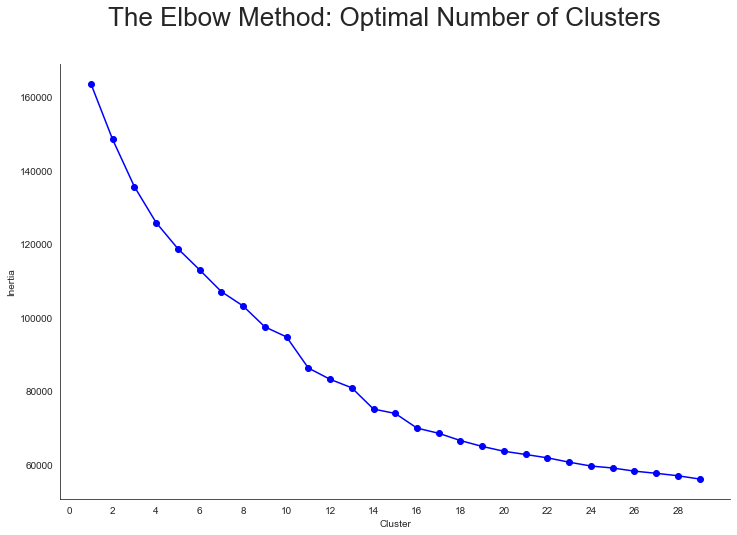

In [13]:
k = pd.concat(km_list, axis=1).T[['clusters','inertia']]

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')

plt.plot(k['clusters'], k['inertia'], 'bo-')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top','right']:
    ax.spines[i].set_visible(False)

ax.set_xticks(range(0, 30, 2))
ax.set(xlabel='Cluster', ylabel='Inertia')

plt.suptitle('The Elbow Method: Optimal Number of Clusters', size=26)
plt.show()

In [14]:
kmeans = KMeans(n_clusters=17, max_iter=300, n_init=10, random_state=59)
kmeans.fit(X_train_st)

predicted_clusters_train = kmeans.predict(X_train_st)
X_train_st = np.column_stack((X_train_st, predicted_clusters_train))

predicted_clusters_val = kmeans.predict(X_val_st)
X_val_st = np.column_stack((X_val_st, predicted_clusters_val))

In [15]:
svm = SVC()
svm.fit(X_train_st, y_train)
y_pred = svm.predict(X_val_st)

In [16]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_val, y_pred))
print('F1 Score', f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89       699
           1       0.97      0.80      0.87       762

    accuracy                           0.88      1461
   macro avg       0.89      0.88      0.88      1461
weighted avg       0.89      0.88      0.88      1461

F1 Score 0.8733812949640287
